# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

In [11]:
# TODO: generate and plot data with error bars

kwargs = {'N':100, 'H0':73.0, 'M':-19.3, 'zmin':0.01, 'zmax':0.08,'sigma_meas':0.1, 'sigma_int':0.1, 'v_pec':300.0,}
obj_sample = SNSample.make_synthetic_sample = make_synthetic_sample(**kwargs)
z = obj_sample.z
m = obj_sample.m
sigma_m = obj_sample.sigma_m   

In [12]:
z_true = np.linspace(0, 0.1, 100)
m_model = mag_model(z, kwargs['H0'], kwargs['M'])


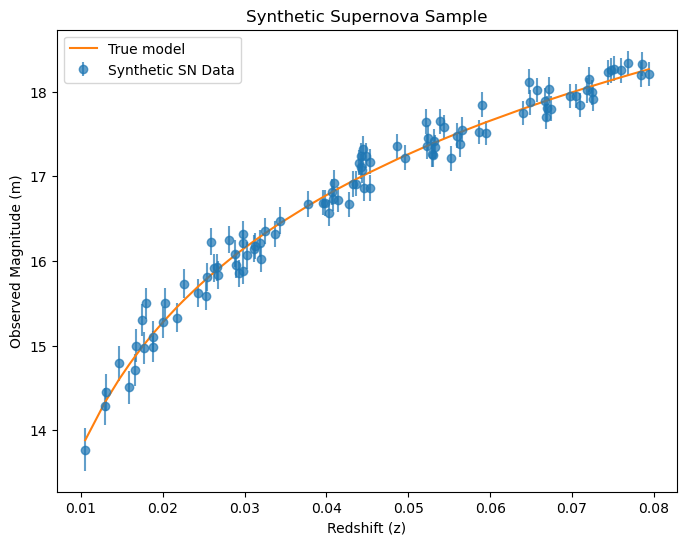

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(z, m, yerr=sigma_m, fmt='o', label='Synthetic SN Data', alpha=0.7)
ax.plot(z,m_model, label='True model' )
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Observed Magnitude (m)')
ax.set_title('Synthetic Supernova Sample')
ax.legend()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [ ]:
# TODO: define chi2 function


def chi2(theta, x, y, sigma):
    res = np.sum(((mag_model(x, *theta)-y)/sigma)**2,axis=0)
    return res

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

In [42]:
H0_val = np.linspace(70,76,500)
theta = (H0_val, kwargs['M'])
chi2_val = []
for h0 in H0_val:
    theta = (h0, kwargs['M'])
    chi2_val.append(chi2(theta,z,m,sigma_m))

In [43]:
chi2_val = np.array(chi2_val)
H0_min = H0_val[np.argmin(chi2_val)]


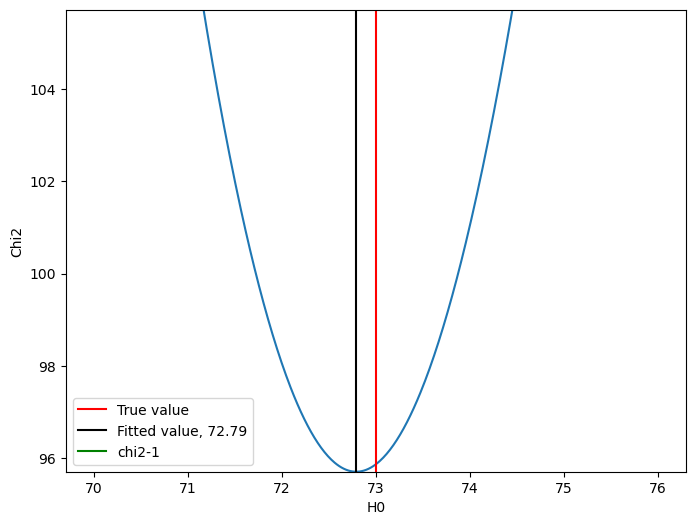

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(H0_val, chi2_val)
ax.axvline(kwargs['H0'], label='True value', color='r',)
ax.axvline(H0_min, label=f'Fitted value, {H0_min:.2f}', color='k')
ax.axhline(np.min(chi2_val)-1,color='g',label='chi2-1')
ax.set_ylim(np.min(chi2_val), np.min(chi2_val)+10.)
ax.set_ylabel('Chi2')
ax.set_xlabel('H0')
ax.legend()

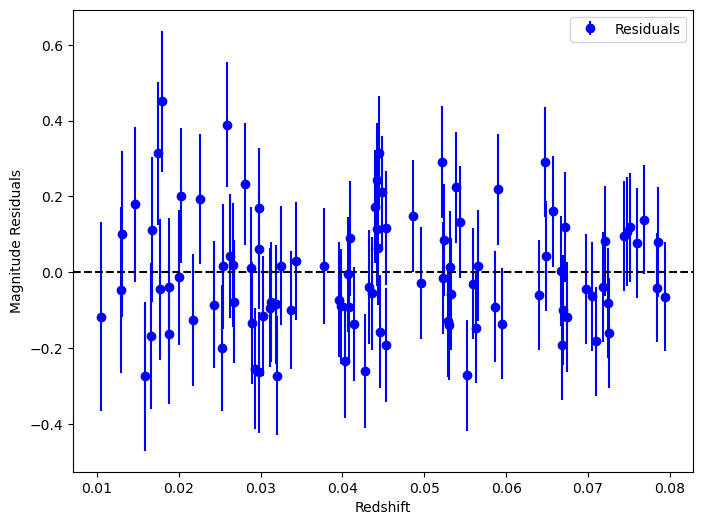

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
residuals = m - mag_model(z, H0_min, kwargs['M'])
ax.errorbar(z, residuals,yerr=sigma_m, label='Residuals', color='b',fmt='o')
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Redshift')
ax.set_ylabel('Magnitude Residuals')
ax.legend()

In [23]:
# TODO: use numpy or scipy to minimize chi2
import scipy
H0_ic, M_ic = 70, -20
IC = np.array([H0_ic, M_ic])
res = scipy.optimize.minimize(chi2, IC, args=(z, m, sigma_m))
chi2_fit = res.fun
H0_fit, M_fit = res.x
print(f"Minimization found H0 = {H0_fit}, M = {M_fit}, with chi2_min = {chi2_fit}")
   

Minimization found H0 = 70.00888842080452, M = -19.384609917340203, with chi2_min = 95.71122948033283


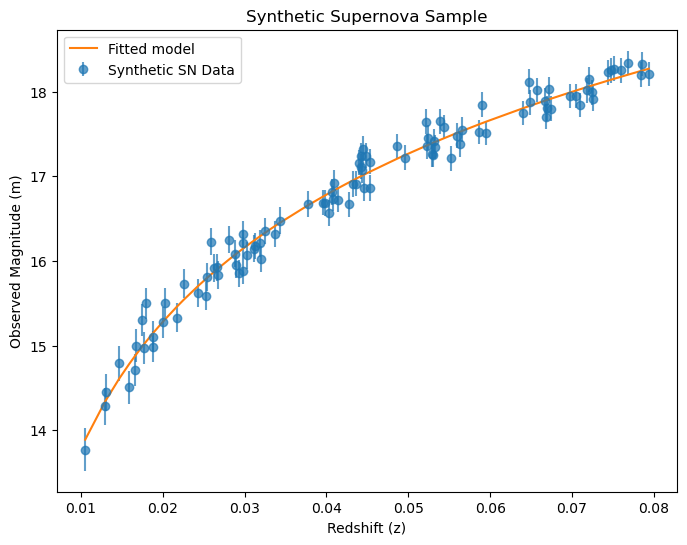

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(z, m, yerr=sigma_m, fmt='o', label='Synthetic SN Data', alpha=0.7)
m_fit = mag_model(z, H0_fit, M_fit)
ax.plot(z,m_fit, label='Fitted model' )
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Observed Magnitude (m)')
ax.set_title('Synthetic Supernova Sample')
ax.legend()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

In [68]:
# TODO: implement bootstrap loop, any ideas how to do this?

n_boot = 1000

idx = np.arange(0,len(z),1)
H0_val = np.linspace(70,76,500)

H0s = np.zeros(n_boot)
for i in range(n_boot):
    rng = np.random.default_rng(i)
    idx_boot = rng.choice(idx,size=len(idx),replace=True)
    z_boot = z[idx_boot]
    m_boot = m[idx_boot]

    chi2_val = []
    for h0 in H0_val:
        theta = (h0, kwargs['M'])
        chi2_val.append(chi2(theta,z_boot,m_boot,sigma_m))
    chi2_val = np.array(chi2_val)
    H0_min = H0_val[np.argmin(chi2_val)]
    H0s[i] = H0_min


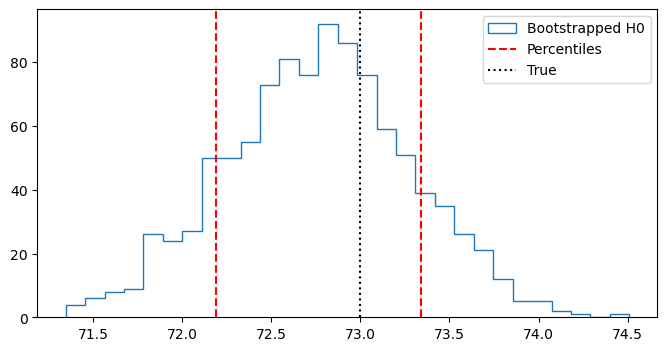

In [76]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
bins = np.linspace(np.min(H0s), np.max(H0s),30)
ax.hist(H0s, histtype = 'step', bins=bins,label = 'Bootstrapped H0')
ax.axvline(np.nanpercentile(H0s,14),ls='--',c='r')
ax.axvline(np.nanpercentile(H0s,86),ls='--',c='r',label = "Percentiles")
ax.axvline(kwargs['H0'],ls = ':', c = 'k', label = 'True')
ax.legend()


### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [ ]:
# TODO: let's calculate a p-value from the sampled probability

def p_val(x,sample):
    mask = sample>x
    p_value = np.sum(mask)/len(sample)
    return p_value

pval_true = p_val(kwargs['H0'],H0s)
print(f"The true value has a p-value = {pval_true:.1e}")

The true value has a p-value = 3.3e-01


### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [ ]:
# TODO: implement grid posterior evaluation

def prior_unif(x,xmin=-30, xmax=-10):
    p = np.where((x>xmin)&(x<xmax),1/(xmax-xmin),0)
    return p

def prior_gauss(x,mu=70,sigma=10):
    return np.exp(-0.5*((x-mu)/sigma)**2)

def ll(theta,x,y,sigma):
    y_model = mag_model(x, *theta)
    single = 0.5*np.log(2*np.pi*sigma**2) - 0.5*(y-y_model)**2/sigma**2
    return np.sum(single)

def posterior(x,y,sigma,theta_range=((65,75),(-22,-25)),npoints = 100):
    pass



### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare